# Fetching observations from Havvarsel Frost (havvarsel-frost.met.no) and Frost (frost.met.no) 

This notebook constructs a dataset containing oceanographic observations from havvarsel frost accomplished with neighboring atmospheric observations from frost

Havvarsel frost serves so far `temperature` measurements originated from badevann.no at seven beaches in the south of Norway. 
> Documentation:
> API documentation for obs/badevann http://havvarsel-frost.met.no/docs/apiref#/obs%2Fbadevann/obsBadevannGet 
> Datastructure described on http://havvarsel-frost.met.no/docs/dataset_badevann

From the frost server we retrieve observations from the `n` closest weather observation stations and include the values 
- `air_temperature`
TODO: 
- `wind_speed`
- `relative_humidity`
- `cloud_area_fraction` (which takes values from 0 = no clouds to 8 = fully clouded) 
- `sum(duration_of_sunshinePT1H)`
- `mean(surface_downwelling_shortwave_flux_in_air PT1H)`
- ...

> Documentation:
> API documentation for observations on https://frost.met.no/api.html#!/observations/observations 
> Available elements (params) are listed on https://frost.met.no/elementtable 
> Examples on Frost data manipulation with Python on https://frost.met.no/python_example.html
>
> See also:
> Complete documentation at https://frost.met.no/howto.html 
> Complete API reference at https://frost.met.no/api.html 


TODO processing:
 - Check in `Observations/AvailableTimeSeries` whether requested value exists on Frost for the selected station
 - Tune processing and storing of observational data sets (to suite whatever code that will use the data sets)

TODO data driven prediction:
 - Prototype simple linear regression
 - Prototype ensemble regression 
 - Prototype simple ANN (with Tensorflow and Keras?)
 - ...
"""

In [1]:
# Importing general libraries
import sys
import json
import datetime
import requests
from traceback import format_exc
import pandas as pd
import matplotlib.pyplot as plt
import numpy 

# Importing user defined functionalities
import FrostImporter


## Data from Havvarsel-Frost

The dataset construction relies on the selection of an observation site from the badevann dataset (`id` = 0....6, see badevann.no for further information) and the selection of a time range with `start_time` and `end_time`

In [2]:
# INPUTS
station_id     = "1"

start_time     = "2018-07-01T00:00"
end_time       = "2018-07-31T23:59"

# FrostImporter instance for given time period
frostImporter = FrostImporter.FrostImporter(start_time=start_time, end_time=end_time)



In [3]:
# Fetching data
location, data = frostImporter.havvarsel_frost(station_id)


Trying http://havvarsel-frost.met.no/api/v1/obs/badevann/get?time=2018-07-01T00%3A00%3A00Z%2F2018-07-31T23%3A59%3A00Z&incobs=true&buoyids=1&parameters=temperature
  buoyID    parameter       name      lon      lat
0      1  temperature  Sjøstrand  10.4983  59.7969


## Data from Frost

The frost server requires a client-id which everyone can create for himself on https://frost.met.no/auth/requestCredentials.html


In [4]:
# INPUT Authentifiction id 
client_id = '3cf0c17c-9209-4504-910c-176366ad78ba' # for florian.beiser@sintef.no


### Identify relevant observation locations in Frost

As preparation for the actual timeseries extract, we have to identify the `station_id`s of those locations where measurements in Frost are available


In [5]:
# INPUT number of stations to consider in vicinity
n = 5
param = "air_temperature"

# Retrieving n closest station ids 
station_ids = frostImporter.frost_location_ids(location, n, param, client_id)

Trying https://frost.met.no/sources/v0.jsonld?validtime=2018-07-01%2F2018-07-31&elements=air_temperature
        dist      lat      lon station_id
0   7.422671  10.4358  59.8558    SN19710
1   9.726874  10.3300  59.8190    SN19923
2  10.864339  10.5403  59.8923    SN19430
3  13.359785  10.2598  59.7908    SN19940
4  14.643295  10.7600  59.7940    SN17895


### Example

In the following, we show an example how data from frost can be added to the existing dataset. We add the `air_temperature` for the closest weather station only. 

In [6]:
# Load temperature
param = "air_temperature"

timeseries = frostImporter.frost(station_ids[0],param)

timeseries

Trying https://frost.met.no/observations/v0.csv?referencetime=2018-07-01T00%3A00%3A00Z%2F2018-07-31T23%3A59%3A00Z&sources=SN19710&elements=air_temperature


,index,sourceId,referenceTime,air_temperature(degC),height_above_ground(m),timeOffset,timeResolution,timeSeriesId,performanceCategory,exposureCategory,qualityCode
0,0,sn19710:0,2018-07-01 00:00:00+00:00,10.4,2.0,PT0H,PT1H,0,C,2,0
1,1,sn19710:0,2018-07-01 01:00:00+00:00,10.1,2.0,PT0H,PT1H,0,C,2,0
2,2,sn19710:0,2018-07-01 02:00:00+00:00,9.2,2.0,PT0H,PT1H,0,C,2,0
3,3,sn19710:0,2018-07-01 03:00:00+00:00,8.8,2.0,PT0H,PT1H,0,C,2,0
4,4,sn19710:0,2018-07-01 04:00:00+00:00,9.4,2.0,PT0H,PT1H,0,C,2,0
...,...,...,...,...,...,...,...,...,...,...,...
739,739,sn19710:0,2018-07-31 19:00:00+00:00,18.7,2.0,PT0H,PT1H,0,C,2,0
740,740,sn19710:0,2018-07-31 20:00:00+00:00,18.0,2.0,PT0H,PT1H,0,C,2,0
741,741,sn19710:0,2018-07-31 21:00:00+00:00,17.9,2.0,PT0H,PT1H,0,C,2,0
742,742,sn19710:0,2018-07-31 22:00:00+00:00,17.8,2.0,PT0H,PT1H,0,C,2,0


                           water_temp  SN19710air_temperature0
time                                                          
2018-07-01 07:00:00+00:00        19.3                     18.2
2018-07-01 10:00:00+00:00        20.3                     23.2
2018-07-01 13:00:00+00:00        21.1                     25.7
2018-07-01 16:00:00+00:00        22.1                     26.2
2018-07-02 07:00:00+00:00        19.8                     19.9


[]

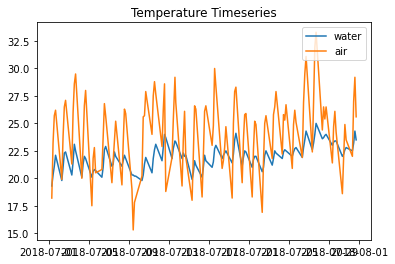

In [10]:
# Select suitable times from the timeseries and add it to data
data4plot = frostImporter.postprocess_frost(timeseries, station_ids[0], param, data)
print(data4plot.head())

# save to csv
data4plot.to_csv("dataset.csv")

#plot
plt.plot(data4plot["water_temp"], label="water")
plt.plot(data4plot[station_ids[0]+param+"0"], label="air")
plt.title("Temperature Timeseries")
plt.legend(loc="upper right")
plt.plot()
